# Fit SNPE to all the successful simulations on **any** morphology that Arco's genetic algorithm has produced
### Code runs on `split-simulate-and-train` branch of `sbi`

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append('../')

import pandas as pd
import torch
import numpy as np

from parameter_setup import load_ground_truth_params, load_prior_max, load_prior_min
from sbi.inference import SNPE, prepare_for_sbi
from sbi.utils import BoxUniform, pairplot, posterior_nn

In [5]:
def drop_columns(data_pd):
    data_no_ss = data_pd.drop(
        columns=[
            "BAC_APheight",
            "BAC_ISI",
            "BAC_ahpdepth",
            "BAC_caSpike_height",
            "BAC_caSpike_width",
            "BAC_spikecount",
            "bAP_APheight",
            "bAP_APwidth",
            "bAP_att2",
            "bAP_att3",
            "bAP_spikecount",
        ]
    )
    data_only_params = data_no_ss.drop(
        columns=[
            "model_id",
            "type_",
            "morphology",
            "lv",
            "seed",
            "max_",
            "gen",
            "hot_zone.outsidescale_sections",
            "morphology.filename",
            "BAC.stim.dist",
            "hot_zone.max_",
            "bAP.hay_measure.recSite2",
            "bAP.hay_measure.recSite1",
            "hot_zone.min_",
            "BAC.hay_measure.recSite",
            "sort_column",
        ]
    )
    return data_only_params

In [6]:
def drop_some_morphologies(df):

    condition1 = df["morphology"] == "84"
    df = df[np.invert(condition1)]
    
    condition2 = df["morphology"] == "85"
    df = df[np.invert(condition2)]
    
    condition3 = df["morphology"] == "91"
    df = df[np.invert(condition3)]
    
    return df

In [23]:
def return_condition_to_drop(df):
    condition1 = df["morphology"] == "84"
    condition2 = df["morphology"] == "85"
    condition3 = df["morphology"] == "91"
    
    return np.logical_and(np.logical_and(np.invert(condition1), np.invert(condition2)), np.invert(condition3)).to_numpy()

In [8]:
# data_trunc.to_pickle("../../../arco_sims/all_simulations_from_GA/toy_set.pickle")

In [9]:
data1_toy = pd.read_pickle(
    "../../../arco_sims/all_simulations_from_GA/toy_set.pickle"
)

In [10]:
data1 = pd.read_pickle(
    "../../../arco_sims/all_simulations_from_GA/selected_BAC_1.pickle"
)

In [11]:
data2 = pd.read_pickle(
    "../../../arco_sims/all_simulations_from_GA/selected_BAC_2.pickle"
)

In [12]:
data3 = pd.read_pickle(
    "../../../arco_sims/all_simulations_from_GA/selected_BAC_3.pickle"
)

In [13]:
full_data = pd.concat([data1, data2, data3])

In [14]:
morphs = full_data["morphology"].drop_duplicates()

In [15]:
morph_dict = {'bifur_dist': {'84': 960.89898892488236,
  '85': 846.72306818393702,
  '86': 974.69441828893309,
  '87': 525.74725964718436,
  '88': 598.66444257173521,
  '89': 484.82033719211557,
  '90': 1014.0388994907497,
  '91': 864.65438930558867,
 '92': 966.02028766897013,
  '92_soma25': 966.02028766897013,
  '93': 902.90861286613904,
  'WR64_Cell8_L5TT_constant_mean': 853.09961470664064,
  'WR64_Cell8_L5TT_constant_mean_max_dendscale_2.0': 853.09961470664064,
  'WR64_Cell8_L5TT_constant_mean_max_dendscale_2.5': 853.09961470664064,
  'WR64_Cell8_L5TT_medfilt': 894.9039938545418,
  'WR69_Cell2_L5TT': 813.24485491265659,
  'WR69_Cell2_L5TT_mean': 816.8211721003031,
  'WR69_Cell2_L5TT_medfilt': 813.24485491265659,
  'WR71_Cell6_L5TT_constant_mean': 322.0802933594905,
  'WR71_Cell6_L5TT_constant_mean_exclude_obliques_from_hot_zone': 322.0802933594905},
'conductance_load_axon': {'84': 198.43087820154383,
  '85': 119.40812716322029,
  '86': 121.14476917803165,
  '87': 286.94003132573692,
  '88': 122.28441447541739,
  '89': 186.80333055353489,
  '90': 103.96884181635856,
  '91': 161.05733021206223,
  '92': 267.3341502629616,
  '92_soma25': 267.3341502629616,
  '93': 265.38012877682729,
  'WR64_Cell8_L5TT_constant_mean': 98.338175886474815,
  'WR64_Cell8_L5TT_constant_mean_max_dendscale_2.0': 98.338175886474815,
  'WR64_Cell8_L5TT_constant_mean_max_dendscale_2.5': 98.338175886474815,
  'WR64_Cell8_L5TT_medfilt': 86.761431870142388,
  'WR69_Cell2_L5TT': 208.96376858418043,
  'WR69_Cell2_L5TT_mean': 220.97370425032707,
  'WR69_Cell2_L5TT_medfilt': 209.9318363678004,
  'WR71_Cell6_L5TT_constant_mean': 195.31885898759177,
  'WR71_Cell6_L5TT_constant_mean_exclude_obliques_from_hot_zone': 195.31885898759177},
'conductance_load_soma': {'84': 86.102705488734472,
  '85': 38.301990510094534,
  '86': 36.148975032437406,
  '87': 86.352292338982679,
  '88': 62.867286424973301,
  '89': 52.921979906220258,
  '90': 76.23477864476682,
  '91': 59.815771986947077,
  '92': 61.795101638029507,
  '92_soma25': 61.795101638029507,
  '93': 69.713392307005961,
  'WR64_Cell8_L5TT_constant_mean': 25.541134994772882,
  'WR64_Cell8_L5TT_constant_mean_max_dendscale_2.0': 25.541134994772882,
  'WR64_Cell8_L5TT_constant_mean_max_dendscale_2.5': 25.541134994772882,
  'WR64_Cell8_L5TT_medfilt': 23.075817229117956,
  'WR69_Cell2_L5TT': 98.122140315343771,
  'WR69_Cell2_L5TT_mean': 41.284338275086554,
  'WR69_Cell2_L5TT_medfilt': 98.579157025082566,
  'WR71_Cell6_L5TT_constant_mean': 27.199895968310145,
  'WR71_Cell6_L5TT_constant_mean_exclude_obliques_from_hot_zone': 27.199895968310145},
'conductance_load_tuft': {'84': 0.71778364778186565,
  '85': 1.1591828765604884,
  '86': 2.801814427678158,
  '87': 0.4331743288869937,
  '88': 0.89948241742635238,
  '89': 0.70850363671023364,
  '90': 2.9236461045594284,
  '91': 0.3683941222392732,
  '92': 0.82455030050106437,
  '92_soma25': 0.82455030050106437,
  '93': 0.91418301357979326,
  'WR64_Cell8_L5TT_constant_mean': 0.64436681672197371,
  'WR64_Cell8_L5TT_constant_mean_max_dendscale_2.0': 0.64436681672197371,
  'WR64_Cell8_L5TT_constant_mean_max_dendscale_2.5': 0.64436681672197371,
  'WR64_Cell8_L5TT_medfilt': 0.74852809427464995,
  'WR69_Cell2_L5TT': 0.92045594223290483,
  'WR69_Cell2_L5TT_mean': 0.92515075012662806,
  'WR69_Cell2_L5TT_medfilt': 0.86835673922736012,
  'WR71_Cell6_L5TT_constant_mean': 0.63525863240125724,
  'WR71_Cell6_L5TT_constant_mean_exclude_obliques_from_hot_zone': 0.63525863240125724},
'length_apical': {'84': 8730.3416850306039,
  '85': 5554.5702080210449,
  '86': 8842.2372710337913,
  '87': 9607.4287894790086,
  '88': 8829.276635837974,
  '89': 7242.7260255588044,
  '90': 6662.4699409038139,
  '91': 4528.6006867385213,
  '92': 9578.3517495762499,
  '92_soma25': 9578.3517495762499,
  '93': 7921.5764982550991,
  'WR64_Cell8_L5TT_constant_mean': 5413.463445582327,
  'WR64_Cell8_L5TT_constant_mean_max_dendscale_2.0': 5413.463445582327,
  'WR64_Cell8_L5TT_constant_mean_max_dendscale_2.5': 5413.463445582327,
  'WR64_Cell8_L5TT_medfilt': 5290.9832657597817,
  'WR69_Cell2_L5TT': 9263.6599168388966,
  'WR69_Cell2_L5TT_mean': 9263.6599168388966,
  'WR69_Cell2_L5TT_medfilt': 9263.6599168388966,
  'WR71_Cell6_L5TT_constant_mean': 7785.7354204037529,
  'WR71_Cell6_L5TT_constant_mean_exclude_obliques_from_hot_zone': 7785.7354204037529},
'length_basal': {'84': 5213.5501871697788,
  '85': 3755.7108581628745,
  '86': 6425.9871596489666,
  '87': 7800.8867368863157,
  '88': 4248.7954774682703,
  '89': 5695.8699854987508,
  '90': 4903.8970190913469,
  '91': 3100.678977321495,
  '92': 7254.0243570991606,
  '92_soma25': 7254.0243570991606,
  '93': 6948.7314703406419,
  'WR64_Cell8_L5TT_constant_mean': 5015.3319238430267,
  'WR64_Cell8_L5TT_constant_mean_max_dendscale_2.0': 5015.3319238430267,
  'WR64_Cell8_L5TT_constant_mean_max_dendscale_2.5': 5015.3319238430267,
  'WR64_Cell8_L5TT_medfilt': 4779.5982454111472,
  'WR69_Cell2_L5TT': 5244.3723553339414,
  'WR69_Cell2_L5TT_mean': 5244.3723553339414,
  'WR69_Cell2_L5TT_medfilt': 5244.3723553339414,
  'WR71_Cell6_L5TT_constant_mean': 6837.0748368982377,
  'WR71_Cell6_L5TT_constant_mean_exclude_obliques_from_hot_zone': 6837.0748368982377},
'length_soma': {'84': 10.605161226552406,
  '85': 20.461987115529251,
  '86': 22.161881977987637,
  '87': 16.670657191436693,
  '88': 11.782965017859691,
  '89': 17.099046776791038,
  '90': 6.9099989584936363,
  '91': 12.130290481671842,
  '92': 14.8099486186339,
  '92_soma25': 14.8099486186339,
  '93': 21.378110896535226,
  'WR64_Cell8_L5TT_constant_mean': 22.907422040862052,
  'WR64_Cell8_L5TT_constant_mean_max_dendscale_2.0': 22.907422040862052,
  'WR64_Cell8_L5TT_constant_mean_max_dendscale_2.5': 22.907422040862052,
  'WR64_Cell8_L5TT_medfilt': 22.401865448522926,
  'WR69_Cell2_L5TT': 14.032147304728934,
  'WR69_Cell2_L5TT_mean': 31.039731070753309,
  'WR69_Cell2_L5TT_medfilt': 14.032147304728934,
  'WR71_Cell6_L5TT_constant_mean': 45.458386564079746,
  'WR71_Cell6_L5TT_constant_mean_exclude_obliques_from_hot_zone': 45.458386564079746},
'mean_trunk_diameter': {'84': 3.0036621372577081,
  '85': 1.4146327011788999,
  '86': 1.1597111227834014,
  '87': 4.1411282118330179,
  '88': 1.6488379469670693,
  '89': 2.4160655847419021,
  '90': 1.1704306100809529,
  '91': 2.9298624229421195,
  '92': 2.9936023129857423,
  '92_soma25': 2.9936023129857423,
  '93': 3.2369513554801501,
  'WR64_Cell8_L5TT_constant_mean': 1.6318931995452302,
  'WR64_Cell8_L5TT_constant_mean_max_dendscale_2.0': 1.6318931995452302,
  'WR64_Cell8_L5TT_constant_mean_max_dendscale_2.5': 1.6318931995452302,
  'WR64_Cell8_L5TT_medfilt': 1.5285454381197554,
  'WR69_Cell2_L5TT': 2.6807773235184791,
  'WR69_Cell2_L5TT_mean': 2.7089173483535074,
  'WR69_Cell2_L5TT_medfilt': 2.6807773235184791,
  'WR71_Cell6_L5TT_constant_mean': 2.4977956709368816,
  'WR71_Cell6_L5TT_constant_mean_exclude_obliques_from_hot_zone': 2.4977956709368816}}

In [16]:
print(morphs)
print(len(morphs))

2                          WR71_Cell6_L5TT_constant_mean
32     WR71_Cell6_L5TT_constant_mean_exclude_obliques...
113                                                   84
245                                                   85
69                                                    86
0                                                     89
775                                                   91
106                                                   87
71                                                    88
549                                                   90
745                                                   93
9                          WR64_Cell8_L5TT_constant_mean
455      WR64_Cell8_L5TT_constant_mean_max_dendscale_2.0
690      WR64_Cell8_L5TT_constant_mean_max_dendscale_2.5
538                              WR64_Cell8_L5TT_medfilt
273                                 WR69_Cell2_L5TT_mean
5                                WR69_Cell2_L5TT_medfilt
Name: morphology, dtype: object

In [107]:
full_data_trunc = full_data[::20]

In [108]:
len(full_data_trunc)

450000

In [109]:
features = torch.zeros(len(full_data_trunc), 8)

for feature_ind, feature_name in enumerate(list(morph_dict.keys())):
    for m in morphs:
        is_this_morph = (full_data_trunc["morphology"] == m)
        features[is_this_morph.to_numpy(), feature_ind] = morph_dict[feature_name][m]

In [110]:
features.shape

torch.Size([450000, 8])

In [111]:
newdf = drop_some_morphologies(full_data_trunc)
condition_to_drop = return_condition_to_drop(full_data_trunc)

In [112]:
condition_to_drop

array([ True,  True,  True, ...,  True,  True,  True])

In [113]:
features = features[condition_to_drop]

In [114]:
dataframe_with_some_morphs = drop_columns(newdf)

### Shuffle data

In [115]:
theta = torch.as_tensor(dataframe_with_some_morphs.to_numpy(), dtype=torch.float32)
x = features

In [116]:
theta.shape

torch.Size([401347, 35])

In [117]:
x.shape

torch.Size([401347, 8])

from pyknos.nflows import distributions as distributions_
from pyknos.nflows import flows, transforms
from pyknos.nflows.nn import nets
from torch import Tensor, nn, relu, tanh

from sbi.utils.sbiutils import standardizing_net, standardizing_transform
from sbi.utils.torchutils import create_alternating_binary_mask
### Define hyperparameters for inference

In [122]:
num_datapoints = 350000
num_hiddens = 100
num_transforms = 5
training_batch_size = 200
max_num_epochs = 300
stop_after_epochs = 10
num_bins = 20

### Define ingredients for SNPE

In [123]:
prior = BoxUniform(torch.as_tensor(load_prior_min()), torch.as_tensor(load_prior_max()))

In [124]:
theta_train = theta[:num_datapoints]
x_train = x[:num_datapoints]
print("Number of training points: ", theta_train.shape[0])

Number of training points:  350000


### Plot gt samples

In [125]:
# limits = np.asarray([load_prior_min(), load_prior_max()])
# _ = pairplot(theta_train[:10000], subset=[0,1,2,3,4,5], limits=limits.T, ticks=limits.T, upper='kde', diag='kde')

### Set up SNPE

In [130]:
net_builder = posterior_nn(
    "nsf",
    z_score_theta=True,
    z_score_x=True,
    hidden_features=num_hiddens,
    num_transforms=num_transforms,
    #num_bins_nsf=num_bins
)

In [131]:
inference = SNPE(prior, density_estimator=net_builder)

In [132]:
inference = inference.append_simulations(theta_train, x_train, proposal=None)

In [133]:
_ = torch.manual_seed(0)

density_estimator = inference.train(
    training_batch_size=training_batch_size,
    max_num_epochs=max_num_epochs,
    stop_after_epochs=stop_after_epochs,
)

Neural network successfully converged after 93 epochs.


In [134]:
posterior = inference.build_posterior()

In [135]:
# import pickle
# with open('../results/samples/201123_SNPE_300epochs_GA_data_bigger_net_training_data.pickle', 'wb') as handle:
#     pickle.dump(theta_train.detach().numpy(), handle, protocol=2)

In [136]:
# import pickle
# with open('../results/samples/201123_SNPE_300epochs_GA_data_bigger_net.pickle', 'wb') as handle:
#     pickle.dump(samples.detach().numpy(), handle, protocol=2)

In [137]:
import pickle
with open('../results/samples/210118_SNPE_condition_on_morph.pickle', 'wb') as handle:
    pickle.dump(posterior, handle, protocol=2)

### Obtaining the support

In [138]:
# class posterior_support:
#     def __init__(self, posterior, prior, num_samples_to_estimate_support: int = 50_000):
#         samples = posterior.sample((num_samples_to_estimate_support,))
#         log_probs = posterior.log_prob(samples)
#         self.thr = torch.min(log_probs)
#         print('self.thr', self.thr)
#         self.thr = torch.tensor([10.0])

#     def sample(self, sample_shape: torch.Size):
#         """
#         Sample from the posterior support.

#         This is done by sampling from the prior and accepting samples only if
#         their posterior-log-probability is larger than some threshold. The
#         threshold is chosen to be the minimum log-prob of 50_000 posterior
#         samples (see `num_samples_to_estimate_support` in `__init__()`).
#         """
#         all_accepted = []
#         num_samples = torch.Size(sample_shape).numel()
#         num_remaining = num_samples
#         total_drawn = 0
#         while num_remaining > 0:
#             num_to_draw = torch.max(torch.tensor([num_remaining]), torch.tensor([10_000]))
#             prior_samples = prior.sample((num_to_draw,))
#             posterior_log_probs = posterior.log_prob(prior_samples)
#             accepted_samples = prior_samples[posterior_log_probs > self.thr]
#             all_accepted.append(accepted_samples)
#             num_remaining -= accepted_samples.shape[0]
#             total_drawn += num_to_draw
#         print("Accepted", torch.cat(all_accepted).shape[0], 'samples out of', total_drawn, 'candidate samples.')
#         frac = torch.as_tensor(torch.cat(all_accepted).shape[0], dtype=torch.float32)/total_drawn
#         print("The fraction of accepted samples is: ", frac)
#         print("The speed-up is:  ", 1/frac)
#         return torch.cat(all_accepted)[:num_samples]

#     def log_prob():
#         raise NotImplementedError

In [139]:
# # Then, after the first round is finished, you can do.
# proposal = posterior_support(posterior, prior, num_samples_to_estimate_support=10_000)

In [140]:
# _ = torch.manual_seed(1)
# support_theta = proposal.sample((1_000,))

In [141]:
# limits = np.asarray([load_prior_min(), load_prior_max()])
# _ = pairplot(support_theta, subset=[0,1,2,3,4,5], limits=limits.T, ticks=limits.T, upper='kde', diag='kde')

In [142]:
# with open('../results/samples/201123_SNPE_300epochs_GA_data_bigger_net_posterior.pickle', 'rb') as handle:
#     posterior_new = pickle.load(handle)

### Plot a histogramm of prior sample log_probs and density log_probs

In [143]:
data_morph1 = full_data_trunc[full_data_trunc["morphology"] == '84']
data_morph2 = full_data_trunc[full_data_trunc["morphology"] == '85']
data_morph3 = full_data_trunc[full_data_trunc["morphology"] == '91']

data_morph1 = drop_columns(data_morph1)
data_morph2 = drop_columns(data_morph2)
data_morph3 = drop_columns(data_morph3)

data_morph1 = torch.as_tensor(data_morph1.to_numpy(), dtype=torch.float32)
data_morph2 = torch.as_tensor(data_morph2.to_numpy(), dtype=torch.float32)
data_morph3 = torch.as_tensor(data_morph3.to_numpy(), dtype=torch.float32)

In [144]:
features_of_84 = torch.zeros(1, 8)
features_of_85 = torch.zeros(1, 8)
features_of_91 = torch.zeros(1, 8)

for feature_ind, feature_name in enumerate(list(morph_dict.keys())):
    features_of_84[0, feature_ind] = morph_dict[feature_name]['84']
    features_of_85[0, feature_ind] = morph_dict[feature_name]['85']
    features_of_91[0, feature_ind] = morph_dict[feature_name]['91']

In [145]:
import matplotlib.pyplot as plt

In [146]:
theta_test = torch.as_tensor(theta[:10000], dtype=torch.float32)
x_test = torch.as_tensor(x[:10000], dtype=torch.float32)

In [147]:
prior_lp = posterior.log_prob(prior.sample((10000,)), x=features_of_84)

In [148]:
x_test.shape

torch.Size([10000, 8])

In [149]:
gt_lp = []
for y, z in zip(theta_test[:100], x_test[:100]):
    gt_lp.append(posterior.log_prob(y, z))

In [151]:
gt_lp = torch.cat(gt_lp)

In [152]:
morph1_lp = posterior.log_prob(data_morph1[:10000], x=features_of_84)

In [153]:
morph2_lp = posterior.log_prob(data_morph2[:10000], x=features_of_84)

In [101]:
# morph3_lp = posterior.log_prob(data_morph3[:10000], x=features_of_91)

In [154]:
# more_gt_lp = posterior.log_prob(theta_test[:300000])

# sorted_gt_lp, _ = torch.sort(more_gt_lp)

# pointzeroone_percent = sorted_gt_lp[int(0.0001*(sorted_gt_lp.shape[0]))]
# print(pointzeroone_percent)

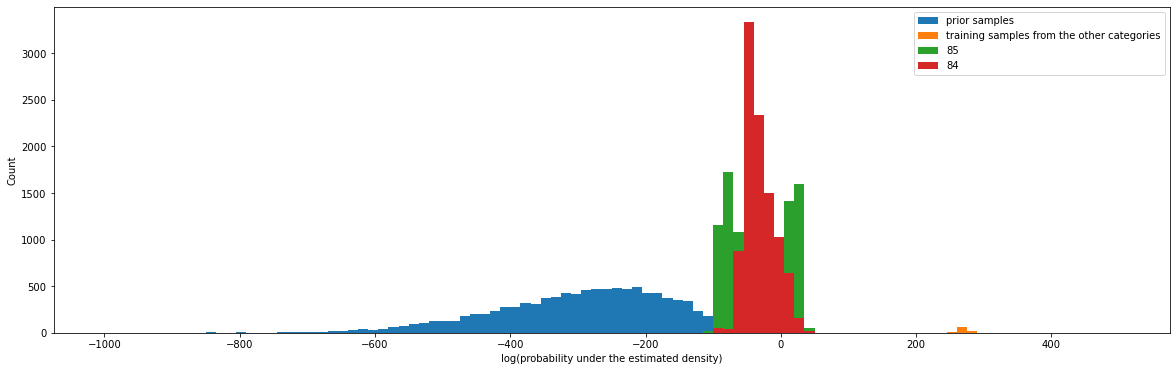

In [155]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
priorhist = ax.hist(prior_lp.unsqueeze(1).numpy(), range=[-1000, 500], bins=100)
posthist = ax.hist(gt_lp.unsqueeze(1).numpy(), range=[-1000, 500], bins=100)
morph2_hist = ax.hist(morph2_lp.unsqueeze(1).numpy(), range=[-1000, 500], bins=100)
morph1_hist = ax.hist(morph1_lp.unsqueeze(1).numpy(), range=[-1000, 500], bins=100)
# morph3_hist = ax.hist(morph3_lp.unsqueeze(1).numpy(), range=[-1000, 500], bins=100)
ax.set_xlabel("log(probability under the estimated density)")
ax.set_ylabel("Count")
ax.legend(["prior samples", "training samples from the other categories", "85", "84", "91"])
# ax.axvline(torch.min(gt_lp))

In [109]:
torch.min(morph2_lp)

tensor(-11.1211)

In [112]:
(prior_lp > -11.1211).sum()

tensor(120)

In [113]:
len(prior_lp)

10000

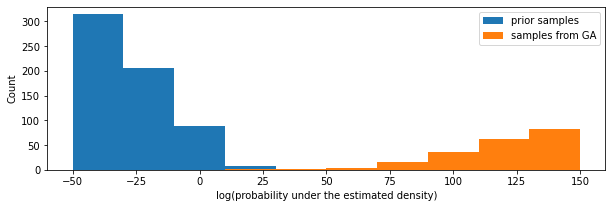

In [207]:
fig, ax = plt.subplots(1,1,figsize=(10,3))
priorhist = ax.hist(prior_lp.unsqueeze(1).numpy(), range=[-50, 150], bins=10)
posthist = ax.hist(gt_lp.unsqueeze(1).numpy(), range=[-50, 150], bins=10)
ax.set_xlabel("log(probability under the estimated density)")
ax.set_ylabel("Count")
ax.legend(["prior samples", "samples from GA"])

In [292]:
more_gt_lp = posterior_new.log_prob(theta_test[:300000])

In [295]:
sorted_gt_lp, _ = torch.sort(more_gt_lp)

zero_percent = sorted_gt_lp[int(0.0*(sorted_gt_lp.shape[0]))]
print(zero_percent)

pointzeroone_percent = sorted_gt_lp[int(0.0001*(sorted_gt_lp.shape[0]))]
print(pointzeroone_percent)

pointone_percent = sorted_gt_lp[int(0.001*(sorted_gt_lp.shape[0]))]
print(pointone_percent)

one_percent = sorted_gt_lp[int(0.01*(sorted_gt_lp.shape[0]))]
print(one_percent)

tensor(-4.7912)
tensor(39.6355)
tensor(76.5995)
tensor(125.4237)


Text(0, 0.5, 'Count')

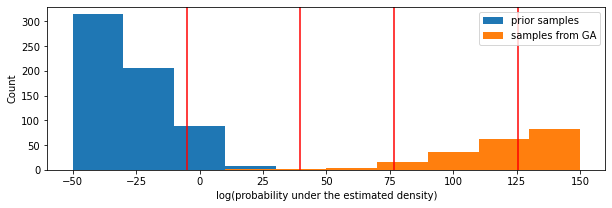

In [296]:
fig, ax = plt.subplots(1,1,figsize=(10,3))
priorhist = ax.hist(prior_lp.unsqueeze(1).numpy(), range=[-50, 150], bins=10)
posthist = ax.hist(gt_lp.unsqueeze(1).numpy(), range=[-50, 150], bins=10)
ax.legend(["prior samples", "samples from GA"])
line1 = ax.axvline(zero_percent, color='r')
line2 = ax.axvline(pointzeroone_percent, color='r')
line3 = ax.axvline(pointone_percent, color='r')
line4 = ax.axvline(one_percent, color='r')
ax.set_xlabel("log(probability under the estimated density)")
ax.set_ylabel("Count")

Text(0, 0.5, 'Count')

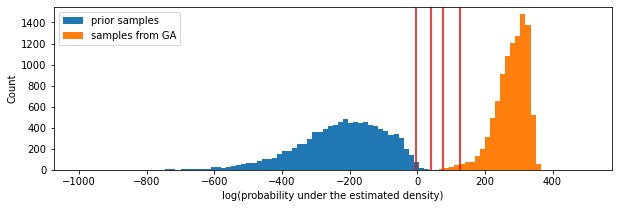

In [297]:
fig, ax = plt.subplots(1,1,figsize=(10,3))
priorhist = ax.hist(prior_lp.unsqueeze(1).numpy(), range=[-1000, 500], bins=100)
posthist = ax.hist(gt_lp.unsqueeze(1).numpy(), range=[-1000, 500], bins=100)
ax.legend(["prior samples", "samples from GA"])
line1 = ax.axvline(zero_percent, color='r')
line2 = ax.axvline(pointzeroone_percent, color='r')
line3 = ax.axvline(pointone_percent, color='r')
line4 = ax.axvline(one_percent, color='r')
ax.set_xlabel("log(probability under the estimated density)")
ax.set_ylabel("Count")

### Get estimates for the rejection rate

In [308]:
class posterior_support_tryout:
    def __init__(self, posterior, prior, num_samples_to_estimate_support: int = 50_000):
        samples = posterior.sample((num_samples_to_estimate_support,))
        log_probs = posterior.log_prob(samples)
        self.thr = torch.min(log_probs)

    def sample(self, sample_shape: torch.Size):
        """
        Sample from the posterior support.

        This is done by sampling from the prior and accepting samples only if
        their posterior-log-probability is larger than some threshold. The
        threshold is chosen to be the minimum log-prob of 50_000 posterior
        samples (see `num_samples_to_estimate_support` in `__init__()`).
        """
        all_accepted = []
        num_samples = torch.Size(sample_shape).numel()
        num_remaining = num_samples
        total_drawn = 0
        num_iterations = 0
        while num_remaining > 0 and total_drawn < 5e7:
            print("New iter", num_iterations)
            num_to_draw = torch.max(torch.tensor([num_remaining]), torch.tensor([100_000]))
            prior_samples = prior.sample((num_to_draw,))
            posterior_log_probs = posterior.log_prob(prior_samples)
            accepted_samples = prior_samples[posterior_log_probs > self.thr]
            all_accepted.append(accepted_samples)
            num_remaining -= accepted_samples.shape[0]
            total_drawn += num_to_draw
            num_iterations += 1
        print("Accepted", torch.cat(all_accepted).shape[0], 'samples out of', total_drawn, 'candidate samples.')
        frac = torch.as_tensor(torch.cat(all_accepted).shape[0], dtype=torch.float32)/total_drawn
        print("The fraction of accepted samples is: ", frac)
        print("The speed-up is:  ", 1/frac)
        return torch.cat(all_accepted)[:num_samples]

    def log_prob():
        raise NotImplementedError

In [309]:
# Then, after the first round is finished, you can do.
proposal_tryout = posterior_support_tryout(posterior, prior, num_samples_to_estimate_support=1_000)
proposal_tryout.thr = zero_percent

In [310]:
_ = torch.manual_seed(0)
support_theta_tryout = proposal_tryout.sample((10_000,))

New iter 0
New iter 1
New iter 2
New iter 3
New iter 4
New iter 5
New iter 6
New iter 7
New iter 8
New iter 9
New iter 10
New iter 11
New iter 12
New iter 13
Accepted 10730 samples out of tensor([1400000]) candidate samples.
The fraction of accepted samples is:  tensor([0.0077])
The speed-up is:   tensor([130.4753])


In [311]:
# Then, after the first round is finished, you can do.
proposal_tryout = posterior_support_tryout(posterior, prior, num_samples_to_estimate_support=1_000)
proposal_tryout.thr = pointzeroone_percent
_ = torch.manual_seed(0)
support_theta_tryout_pointzeroone = proposal_tryout.sample((10_000,))


New iter 0
New iter 1
New iter 2
New iter 3
New iter 4
New iter 5
New iter 6
New iter 7
New iter 8
New iter 9
New iter 10
New iter 11
New iter 12
New iter 13
New iter 14
New iter 15
New iter 16
New iter 17
New iter 18
New iter 19
New iter 20
New iter 21
New iter 22
New iter 23
New iter 24
New iter 25
New iter 26
New iter 27
New iter 28
New iter 29
New iter 30
New iter 31
New iter 32
New iter 33
New iter 34
New iter 35
New iter 36
New iter 37
New iter 38
New iter 39
New iter 40
New iter 41
New iter 42
New iter 43
New iter 44
New iter 45
New iter 46
New iter 47
New iter 48
New iter 49
New iter 50
New iter 51
New iter 52
New iter 53
New iter 54
New iter 55
New iter 56
New iter 57
New iter 58
New iter 59
New iter 60
New iter 61
New iter 62
New iter 63
New iter 64
New iter 65
New iter 66
New iter 67
New iter 68
New iter 69
New iter 70
New iter 71
New iter 72
New iter 73
New iter 74
New iter 75
New iter 76
New iter 77
New iter 78
New iter 79
New iter 80
New iter 81
New iter 82
New iter 83
N

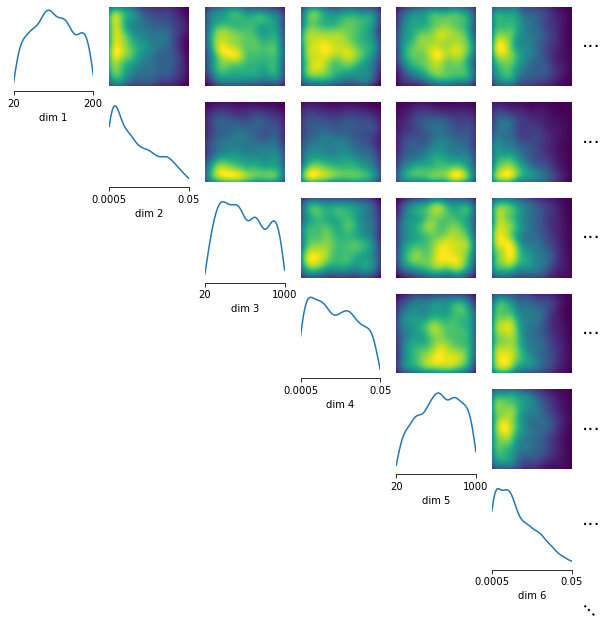

In [314]:
limits = np.asarray([load_prior_min(), load_prior_max()])
_ = pairplot(support_theta_tryout_pointzeroone, subset=[0,1,2,3,4,5], limits=limits.T, ticks=limits.T, upper='kde', diag='kde')

In [313]:
import pickle
with open('../results/samples/201123_SNPE_300epochs_GA_data_bigger_net_samples_from_support_pointonepercentquantile.pickle', 'wb') as handle:
    pickle.dump(support_theta_tryout_pointzeroone.detach().numpy(), handle, protocol=2)

In [ ]:
limits = np.asarray([load_prior_min(), load_prior_max()])
_ = pairplot(support_theta, subset=[0,1,2,3,4,5], limits=limits.T, ticks=limits.T, upper='kde', diag='kde')

In [300]:
pointzeroone_percent

tensor(39.6355)

### Plot histograms over samples drawn from the estimated density

In [191]:
prior_lp = posterior.log_prob(prior.sample((10000,)))
posterior_lp = posterior_new.log_prob(posterior.sample((10000,)))

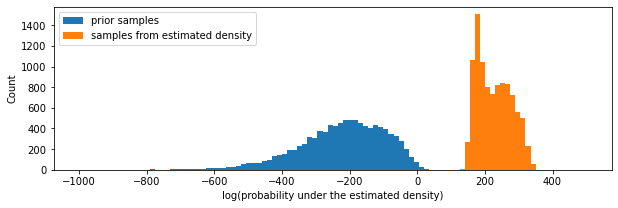

In [192]:
fig, ax = plt.subplots(1,1,figsize=(10,3))
priorhist = ax.hist(prior_lp.unsqueeze(1).numpy(), range=[-1000, 500], bins=100)
posthist = ax.hist(posterior_lp.unsqueeze(1).numpy(), range=[-1000, 500], bins=100)
ax.set_xlabel("log(probability under the estimated density)")
ax.set_ylabel("Count")
ax.legend(["prior samples", "samples from estimated density"])

In [149]:
# import pickle
# with open('../results/samples/201123_SNPE_300epochs_GA_data_bigger_net_supportsamples.pickle', 'wb') as handle:
#     pickle.dump(support_theta.detach().numpy(), handle, protocol=2)